## FluoXAS fit by references

Code for fitting a fluoXAS run from a set of references

# Input variables for this code

In [18]:
mainh5path  = "L1.crop.h5"  # Path and name of the main h5 file with the FluoXAS data
outpath     = "/data/visitor/hg199/id21/20221125/processed/xanes/"  # Path to save all the ouput data ("." is the current working directory)
elemdet     = "/detector0/Ca-K/data"  # Select the element and detector with data by giving the tree path inside the .h5 file
energycntr  = "/detector0/Ca-K/DCM_Energy"  # Select the energy counter by giving the tree path inside the .h5 file
folderwhref = "Ca_K-edge_XANES_spectra-references/fluorescence_mode/*.txt"  # Folder with all the reference data as a .txt or .dat extension. Two column data energy vs abs

yshift      = 0.8 # Add a shift in y to display better the XANES plot, shifty = 0 to plot with no shift

# Imports for this code

In [19]:
from PyMca5.PyMcaPhysics.xas.XASNormalization import XASNormalization
import matplotlib.pyplot as plt
from glob import glob
import numpy
import h5py
import os

# Average of all the FluoXAS data

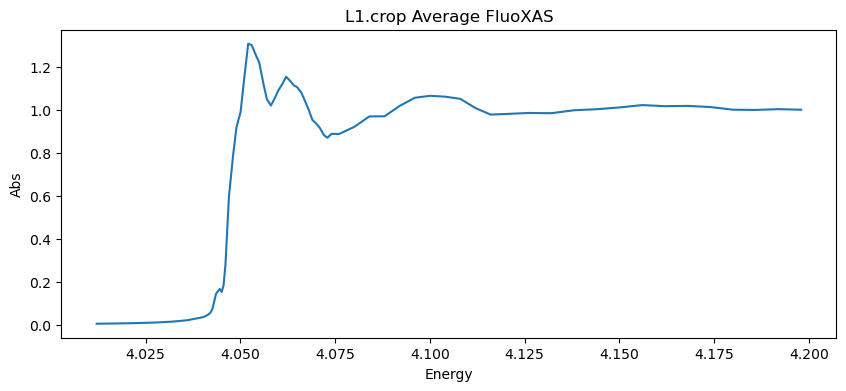

In [20]:
with h5py.File(mainh5path, mode="r") as f:
    energy = f[energycntr][()]
    data = f[elemdet][()]
data /= data[...,None,-1]
datamean = data.mean(axis=(0,1))

plt.figure(figsize=(10,4))
l = plt.plot(energy, datamean)
titlestr = str(mainh5path[:-3])
plt.title(titlestr + " Average FluoXAS")
plt.xlabel("Energy")
plt.ylabel("Abs")
plt.show()

## References

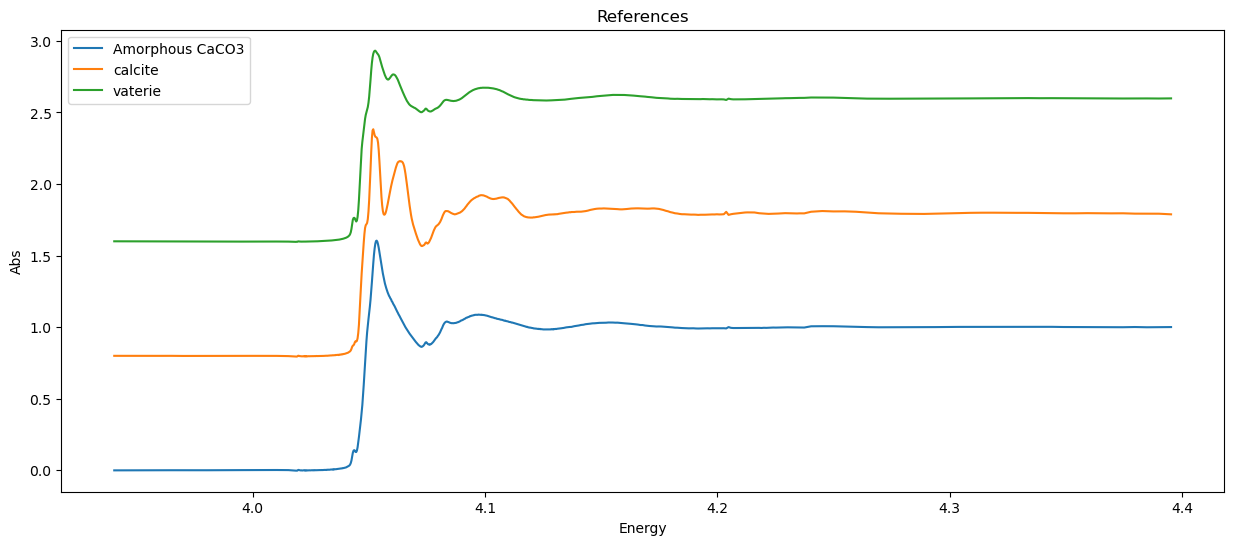

In [21]:
reference = {}

plt.figure(figsize=(15,6))

shiftyplot = 0
for filename in glob(folderwhref):
    refen, refdata = numpy.loadtxt(filename).T
    refdata -= refdata[0]
    if refen[1] >= 1000:
        refen /= 1000
    label = os.path.splitext(os.path.basename(filename))[0]
    reference[label] = {"energy":refen, "data":refdata, "fitdata": numpy.interp(energy, refen, refdata)}
    plt.plot(refen , refdata + shiftyplot, label=label)
    l = plt.legend()
    shiftyplot += yshift

# Uncomment the line below to add the average of the FluoXAS to the plot with the references
#plt.plot(energy, datamean, "o", label="FluoXAS AVG")

l = plt.legend()
plt.title("References")
plt.xlabel("Energy")
plt.ylabel("Abs")
plt.show()

# XANES Normalization
Only run this part of the code if your spectra is not normalized, remember to write "yes" in "norm_choosing"

In [22]:
# Normalization values
norm_choosing = "yes" # Write "yes" to have all XANES data normalized using PyMca functions "no" otherwise 
edge = 4.048          # Values taken from the PyMca GUI, XAS normalization option
pre  = "Constant", -0.033, -0.013
post = "Linear", 0.08, 0.145

def normalization(energy, spectrum, edge, pre, post):
    polynomial_map = {
        "Modif. Victoreen": -2,
        "Victoreen": -1,
        "Constant": 0,
        "Linear": 1,
        "Parabolic": 2,
        "Cubic": 3,
    }
    prename, premin, premax    = pre
    postname, postmin, postmax = post

    pre_edge_regions  = [[premin, premax]]
    post_edge_regions = [[postmin, postmax]]
    algorithm = "polynomial"
    algorithm_parameters = {
        "pre_edge_order": polynomial_map[prename],
        "post_edge_order": polynomial_map[postname],
    }

    result = XASNormalization(
        spectrum=spectrum,
        energy=energy,
        edge=edge,
        pre_edge_regions=pre_edge_regions,
        post_edge_regions=post_edge_regions,
        algorithm=algorithm,
        algorithm_parameters=algorithm_parameters,
    )
    (
        energy,
        normalizedSpectrum,
        edge,
        jump,
        pre_edge_function,
        prePol,
        post_edge_function,
        postPol,
    ) = result
    preLine  = pre_edge_function(prePol, energy)
    postLine = post_edge_function(postPol, energy)
    return normalizedSpectrum, jump, preLine, postLine
    
def plotting(energy, spectrum, normspectrum, file_name):
    plt.figure().suptitle(file_name)
    plt.plot(energy, spectrum)
    plt.vlines([edge], spectrum.min(), spectrum.max(), label="edge", colors=["blue"])
    plt.plot(energy, preLine, label="pre")
    plt.vlines(
        edge + numpy.array(pre[1:]),
        spectrum.min(),
        spectrum.max(),
        label="pre limits",
        colors=["red"],
    )
    plt.plot(energy, preLine + postLine, label="post")
    plt.vlines(
        edge + numpy.array(post[1:]),
        spectrum.min(),
        spectrum.max(),
        label="post limits",
        colors=["green"],
    )
    plt.legend(prop={'size': 8})
    plt.title("Pre Normalization Values")
    plt.xlabel("Energy")
    plt.ylabel("intensity [a.u]")

    plt.figure().suptitle("Normalized " + file_name)
    plt.plot(energy, normspectrum, label="Normalized Spectrum")
    plt.legend(prop={'size': 8})
    plt.xlabel("Energy")
    plt.ylabel("Abs")


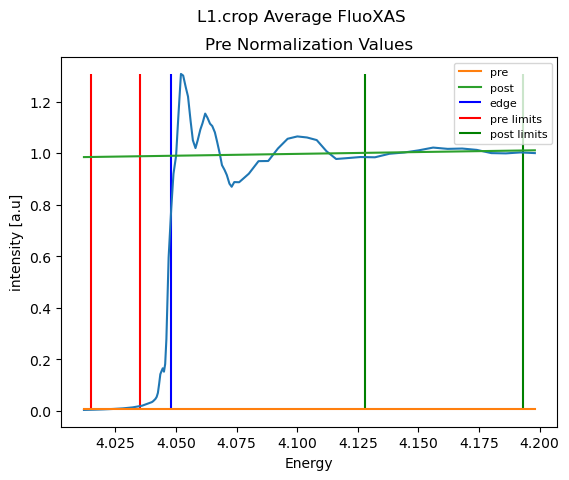

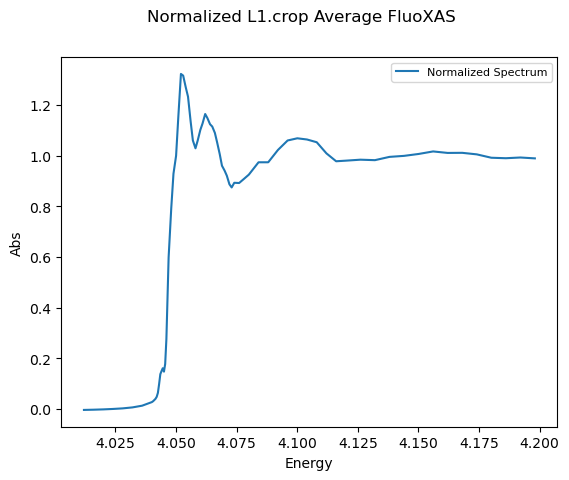

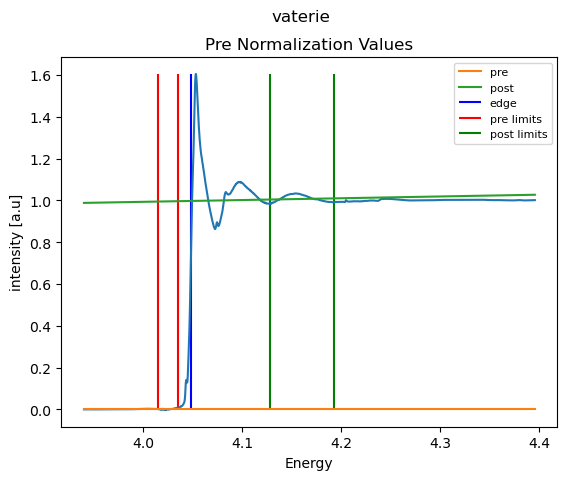

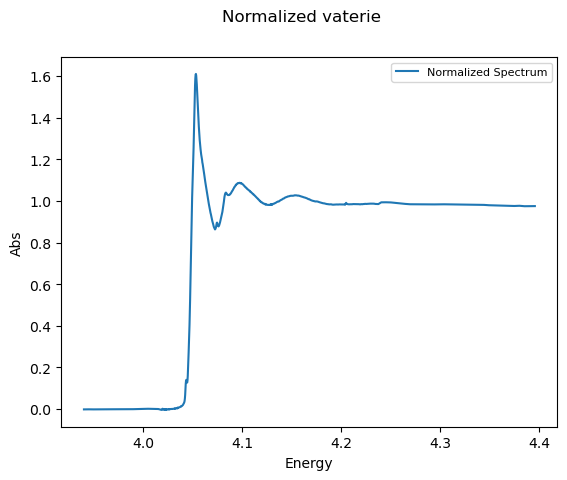

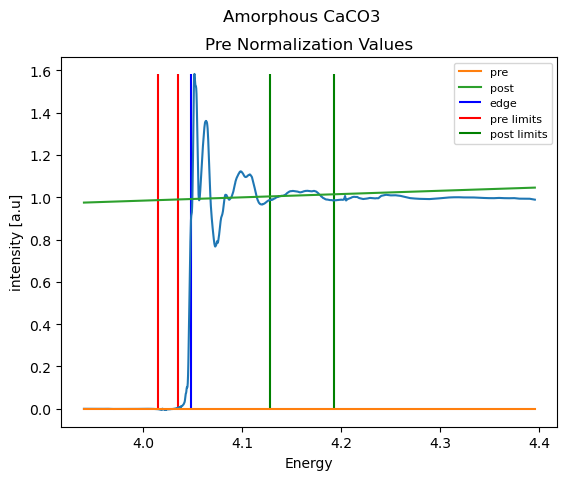

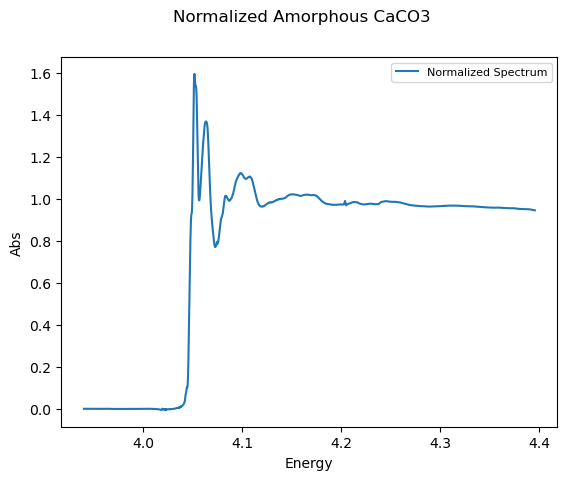

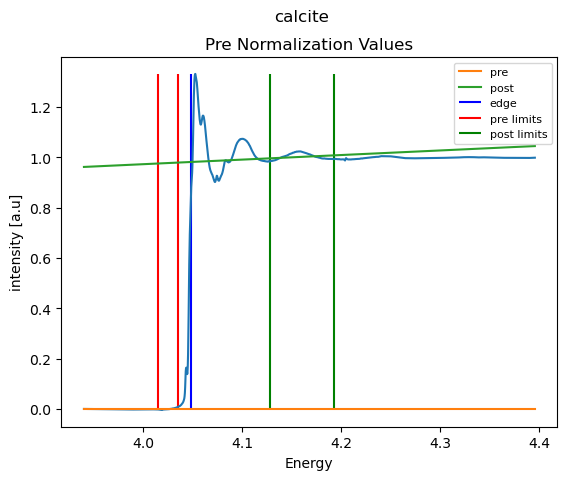

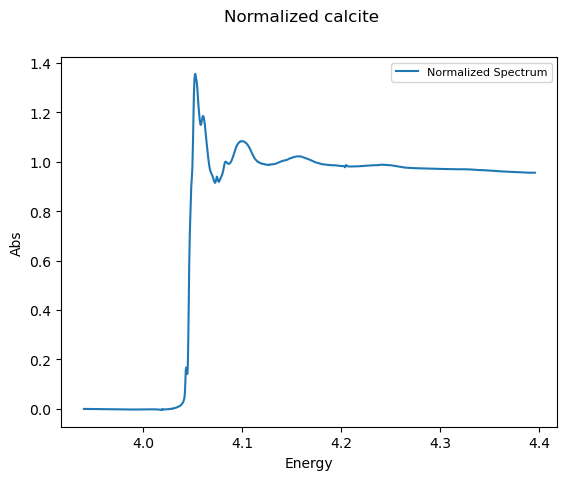

In [23]:
if norm_choosing == "yes":
    normalizedSpectrum, jump, preLine, postLine = normalization(energy, datamean, edge, pre, post)
    plotting(energy, datamean, normalizedSpectrum, titlestr + " Average FluoXAS")
    datamean = normalizedSpectrum

    for filename in glob(folderwhref):
        refen, refdata = numpy.loadtxt(filename).T
        refdata -= refdata[0]
        if refen[1] >= 1000:
            refen /= 1000
        normalizedSpectrum, jump, preLine, postLine = normalization(refen, refdata, edge, pre, post)
        plotting(refen, refdata, normalizedSpectrum, label)
        label = os.path.splitext(os.path.basename(filename))[0]
        reference[label]['data'] = normalizedSpectrum
        
        # Uncomment the line below to add the average of the FluoXAS Avg to the plot with the references
        #plt.plot(energy, datamean, label="FluoXAS AVG")
        
    plt.show()



## Fit fouoxas stack

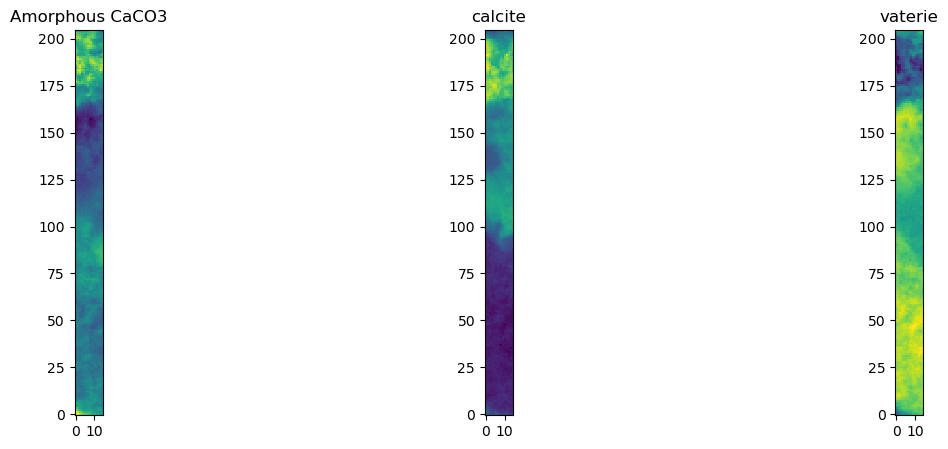

In [24]:
A = numpy.vstack([ref["fitdata"] for name, ref in sorted(reference.items())]).T
s = data.shape
nref = len(reference)
b = data.reshape(s[0]*s[1], s[2]).T
x = numpy.linalg.lstsq(A, b, rcond=None)[0].reshape(3, s[0], s[1])

fig, axes = plt.subplots(1, nref, figsize=(15,5))
for i, (img, (title, ref)) in enumerate(zip(x, sorted(reference.items()))):
    ax1 = axes[i]
    ax1.imshow(img.T, interpolation="nearest", origin="lower")
    ax1.set_title(title)
    
plt.show()

In [25]:
print("FINISH!!!")

FINISH!!!
